### Импорт библиотек

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from joblib import dump
from matplotlib.dates import DateFormatter

### Загрузка данных

In [27]:
train_data = pd.read_csv('../data/price_data.csv')

### Подготовка данных - убедимся, что даты в правильном формате

In [28]:
train_data['dt'] = pd.to_datetime(train_data['dt'])
target_col = 'Цена на арматуру'
X_train = train_data.drop(['dt', target_col], axis=1)
y_train = train_data[target_col]
dates_train = train_data['dt']

### Создание и обучение ARIMA модели

In [29]:
model = ARIMA(y_train, order=(1,1,3))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:       Цена на арматуру   No. Observations:                  428
Model:                 ARIMA(1, 1, 3)   Log Likelihood               -3718.953
Date:                Wed, 26 Mar 2025   AIC                           7447.906
Time:                        23:08:40   BIC                           7468.190
Sample:                             0   HQIC                          7455.918
                                - 428                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9210      0.058     15.881      0.000       0.807       1.035
ma.L1         -0.5369      0.063     -8.481      0.000      -0.661      -0.413
ma.L2         -0.1787      0.036     -4.904      0.0

### Получение прогнозов на тренировочных данных

In [30]:
arima_pred = result.get_prediction(start=X_train.index[0], end=X_train.index[-1])
y_pred = arima_pred.predicted_mean
residuals = y_train - y_pred

### Функция для рекомендаций по закупкам

In [31]:
def calculate_weeks(price, predicted_prices):
    changes = [(p - price)/price*100 for p in predicted_prices]
    avg_change = np.mean(changes)
    max_change = np.max(changes)
    min_change = np.min(changes)
    volatility = max_change - min_change
    trend_strength = abs(avg_change)
    
    if avg_change > 0:  # Рост цен
        if trend_strength > 5 or volatility > 8:
            return 1, f"Минимальная закупка (резкий рост до +{max_change:.1f}%)"
        elif trend_strength > 3:
            return 2, f"Уменьшенная закупка (сильный рост +{avg_change:.1f}%)"
        elif trend_strength > 1:
            return 3, f"Стандартная закупка (рост +{avg_change:.1f}%)"
        else:
            return 4, f"Нормальная закупка (незначительный рост +{avg_change:.1f}%)"
    else:  # Падение цен
        if trend_strength > 5 or volatility > 8:
            return 6, f"Максимальная закупка (резкое падение {min_change:.1f}%)"
        elif trend_strength > 3:
            return 5, f"Увеличенная закупка (падение {avg_change:.1f}%)"
        elif trend_strength > 1:
            return 4, f"Нормальная закупка (незначительное падение {avg_change:.1f}%)"
        else:
            return 3, f"Стандартная закупка (стабильные цены)"

### Прогнозирование на 6 недель вперед

In [32]:
forecast_steps = 6
forecast = result.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

### Получаем рекомендацию

In [33]:
current_price = y_train.iloc[-1]
weeks, recommendation = calculate_weeks(current_price, forecast_values)

print("\n" + "="*50)
print(f"Текущая цена: {current_price:.2f}")
print(f"Прогноз на {forecast_steps} недель: {forecast_values.values.round(2)}")
print(f"Рекомендация: {recommendation}")
print(f"Оптимальный срок закупки: {weeks} недель(и)")
print("="*50 + "\n")


Текущая цена: 55500.00
Прогноз на 6 недель: [55963.35 55720.93 55473.52 55245.65 55035.77 54842.46]
Рекомендация: Стандартная закупка (стабильные цены)
Оптимальный срок закупки: 3 недель(и)



### Визуализация с рекомендацией

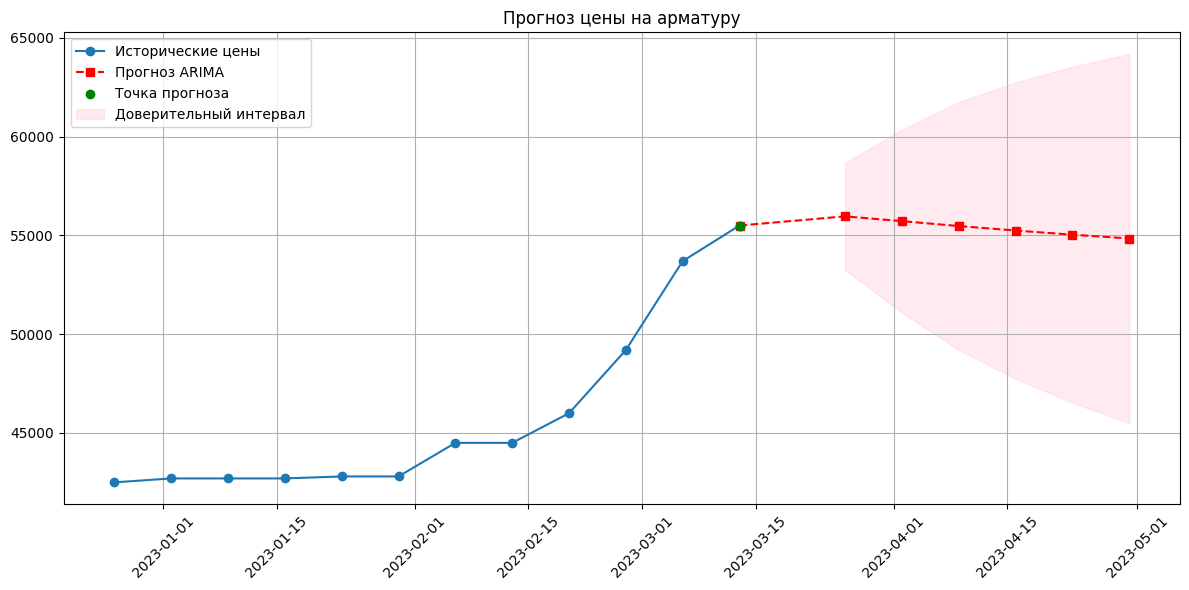

In [34]:
plt.figure(figsize=(12,6))
ax = plt.gca()

# Преобразуем forecast_dates в правильный формат
forecast_dates = pd.date_range(start=dates_train.iloc[-1], periods=forecast_steps+1, freq='W')[1:]

# Объединяем исторические и прогнозные данные для плавного перехода
all_dates = np.concatenate([dates_train.iloc[-12:].values, forecast_dates.values])
all_values = np.concatenate([y_train.iloc[-12:].values, forecast_values.values])

# Создаём общий временной ряд
combined_series = pd.Series(all_values, index=all_dates)

# Отображаем данные
ax.plot(combined_series.index[:12], combined_series.values[:12], 
        label='Исторические цены', marker='o')
ax.plot(combined_series.index[11:], combined_series.values[11:], 
        color='red', label='Прогноз ARIMA', marker='s', linestyle='--')

# Добавляем точку соединения (последняя историческая и первая прогнозная)
ax.scatter([combined_series.index[11]], [combined_series.values[11]], 
           color='green', zorder=5, label='Точка прогноза')

# Доверительный интервал для прогнозной части
ax.fill_between(forecast_dates, 
                conf_int.iloc[:, 0], 
                conf_int.iloc[:, 1], 
                color='pink', alpha=0.3, label='Доверительный интервал')

# Форматирование дат
date_form = DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(date_form)

plt.title(f'Прогноз цены на арматуру')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### Фактические значения и предсказанные

In [35]:
y_actual = y_train  # Истинные значения
y_predicted = arima_pred.predicted_mean  # Прогноз ARIMA

r2 = r2_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train, y_pred)

print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

R²: 0.9725
MSE: 4673749.77
RMSE: 2161.89
MAE: 904.10


### Визуализация фактических и предсказанных значений

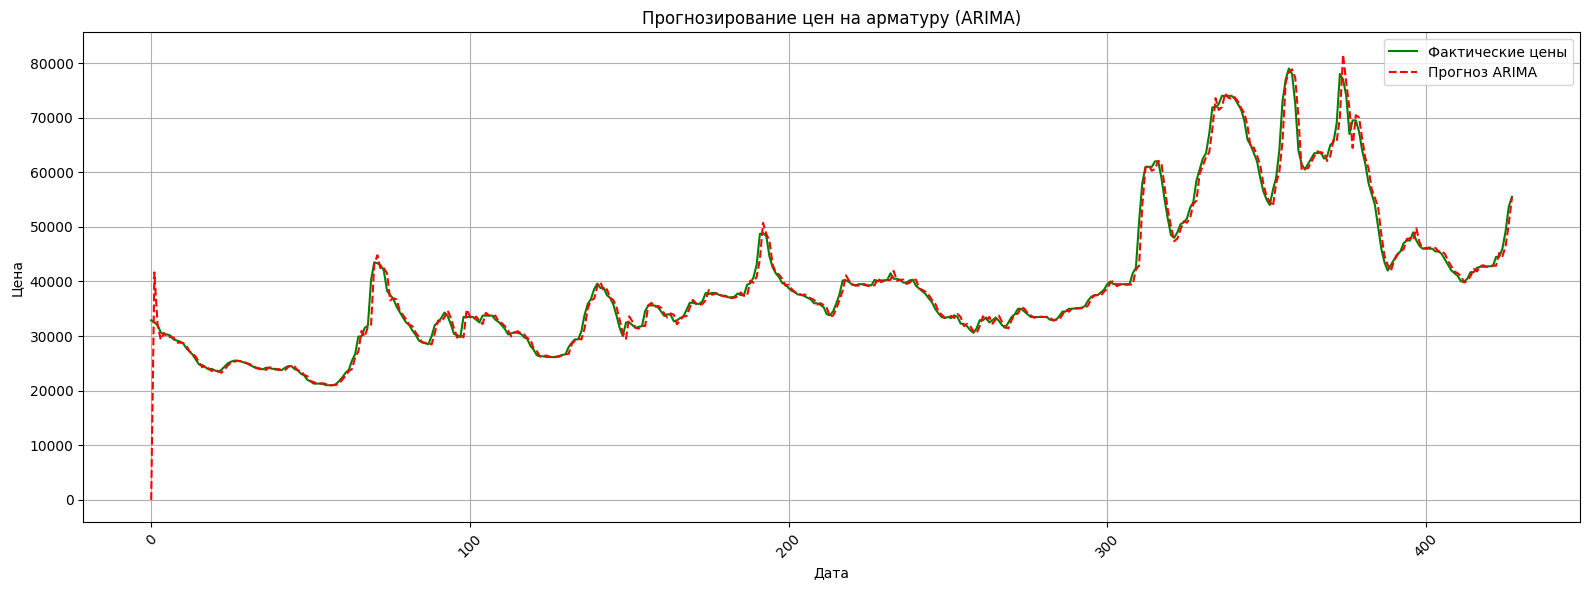

In [36]:
plt.figure(figsize=(16, 6))
plt.plot(y_actual.index, y_actual, label='Фактические цены', color='green')
plt.plot(y_actual.index, y_predicted, label='Прогноз ARIMA', color='red', linestyle='--')
plt.title('Прогнозирование цен на арматуру (ARIMA)')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [37]:
dump(model, 'arima_model.joblib')

['arima_model.joblib']